## Stair Counting with Machine Learning Project
---

##Introduction a l'analyse de l'image
###Groupe 5 / M1 / VMI / UPC / 2024-2025


*   Arris Ismahane
*   Khoualdia Besma
*   Amjad Hadia






---


Processes images of staircases to predict the number of steps using machine learning.

# Import Libraries

In [1]:
import os
import cv2
import math
import numpy as np
import pandas as pd
import gdown
import zipfile
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from google.colab.patches import cv2_imshow

#Import DataSet

In [2]:
!gdown --id 1pZcR6YFhQyhvNcOCPLiB5Ei17p4fXmMh --output groupe5_data.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1pZcR6YFhQyhvNcOCPLiB5Ei17p4fXmMh
From (redirected): https://drive.google.com/uc?id=1pZcR6YFhQyhvNcOCPLiB5Ei17p4fXmMh&confirm=t&uuid=50e1ef1d-8179-402e-8f06-66a2669ba037
To: /content/groupe5_data.zip
100% 145M/145M [00:05<00:00, 28.9MB/s]


In [3]:
with zipfile.ZipFile("groupe5_data.zip", 'r') as zip_ref:
    zip_ref.extractall("groupe5_data")

In [4]:
input_csv = "groupe5_data/annotations.csv"
data = "groupe5_data/stairs_dataset"

#Feature Extraction
Read and pre process the image then extract its features

In [5]:
def extract_features(image_path, target_size=800):
    # Load image
    img = cv2.imread(image_path.strip())

    if img is None:
        print(f"Error: Could not load image at {image_path}")
        return None

    # Resize image if larger than target size
    height, width = img.shape[:2]
    img = cv2.resize(img, (target_size,target_size))
    height, width = img.shape[:2]

    # Convert to grayscale after resizing
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Edge-preserving filter
    blur = cv2.bilateralFilter(img_gray, 9, 75, 75)

    # Generelaized edge detection using canny
    high_thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[0]
    edges = cv2.Canny(blur, max(25, 0.3*high_thresh), min(200, high_thresh))

    # Adaptative line detection using Hough
    min_len = max(10, int(min(height, width) * 0.1))
    lines = cv2.HoughLinesP(edges, 1, np.pi/180,
                            threshold=int(min(height, width) * 0.1),
                            minLineLength=min_len,
                            maxLineGap=int(min(height, width) * 0.03))

    # Line angles clustering
    line_count = 0
    line_angles = []
    if lines is not None:
        lines = np.squeeze(lines)
        if lines.ndim == 1:
            lines = np.array([lines])

        line_count = len(lines)
        for line in lines:
            x1, y1, x2, y2 = line[:4]
            angle = math.degrees(math.atan2(y2-y1, x2-x1))
            line_angles.append(angle)

    # Calculate angle features like mean, std and range
    angle_features = [0, 0, 0]
    if line_angles:
        angle_features = [
            np.mean(line_angles),
            np.std(line_angles),
            max(line_angles) - min(line_angles)
        ]

    # HOG features
    hog_features, hog_image = hog(img_gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)

    return np.hstack([hog_features, line_count, angle_features])

# Data Splitting
Split CSV dataset into train, validation, and test sets

In [6]:
def split_csv(input_csv, file_column, train_size=0.8, val_size=0.1, test_size=0.1, random_state=42):
    df = pd.read_csv(input_csv)

    # 1st split: train and temp (val+test)
    train, temp = train_test_split(df, train_size=train_size, random_state=random_state)

    # 2nd split: temp into val  test
    val, test = train_test_split(temp, train_size=val_size/(val_size+test_size), random_state=random_state)

    return train, val, test

#Data Processing
Load images and extract their features based on given DataFrame

In [7]:
def load_and_process_data(df, image_dir, extract_features_func):
    #feature matrix and target values
    X, y = [], []
    for _, row in df.iterrows():
        # Focus on "name" column to get the images
        image_path = os.path.join(image_dir, row["name"])
        features = extract_features_func(image_path)
        # Skip if feature extraction failed
        if features is not None:
            X.append(features)
            y.append(row["count"])

    if len(X) == 0:
        print("Warning: No valid features extracted!")
        return np.array([]), np.array([])

    return np.array(X), np.array(y)

# Visualization Functions
Plots for comparing between diffrent MAE scores


In [8]:
def visualize_model_comparison(val_results):
    plt.figure(figsize=(8, 6))

    # Get the minimum value and the corresponding model
    min_value = min(val_results.values())
    min_key = [k for k, v in val_results.items() if v == min_value][0]

    # Create a list of colors, with green for the lowest value
    bar_colors = ['#800020' if key == min_key else '#6495ED' for key in val_results.keys()]

    plt.bar(val_results.keys(), val_results.values(), width=0.3, color=bar_colors)
    plt.title('Model Comparison: Validation Set MAE')
    plt.ylabel('Mean Absolute Error')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

A plot to compare between actual and predicted values

In [9]:
def visualize_actual_vs_predicted(y_test, y_pred):

    # Sort by actual values for a better visual
    sorted_indices = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[sorted_indices]
    y_pred_sorted = np.array(y_pred)[sorted_indices]

    bar_width = 0.4
    indices = np.arange(len(y_test))
    # Plot bars
    plt.figure(figsize=(10, 6))
    plt.bar(indices - bar_width/2, y_test_sorted, bar_width, label="Actual", color="blue", alpha=0.7)
    plt.bar(indices + bar_width/2, y_pred_sorted, bar_width, label="Predicted", color="orange", alpha=0.7)

    # Labels and legend
    plt.xlabel("Sample Index")
    plt.ylabel("Count")
    plt.title("Comparison of Actual vs. Predicted Stair Counts")
    plt.xticks(indices)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Main Execution
### Split dataset into train, validation, and test sets


In [10]:
# Main execution starts here
print("Splitting dataset into train, validation, and test sets...")
train_df, val_df, test_df = split_csv(input_csv, 'name')

print(f"Train set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")

# Process all splits using the helper function
print("Extracting features from training set...")
X_train, y_train = load_and_process_data(train_df, data, extract_features)

print("Extracting features from validation set...")
X_val, y_val = load_and_process_data(val_df, data, extract_features)

print("Extracting features from test set...")
X_test, y_test = load_and_process_data(test_df, data, extract_features)

print(f"Processed features shapes: X_train={X_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}")

Splitting dataset into train, validation, and test sets...
Train set: 78 samples
Validation set: 10 samples
Test set: 10 samples
Extracting features from training set...
Error: Could not load image at groupe5_data/stairs_dataset/t3i5.jpg
Error: Could not load image at groupe5_data/stairs_dataset/t3i9.jpg
Error: Could not load image at groupe5_data/stairs_dataset/img4.jpg
Extracting features from validation set...
Extracting features from test set...
Processed features shapes: X_train=(75, 86440), X_val=(10, 86440), X_test=(10, 86440)


### Define multiple models to try

In [11]:
models = {
    "RandomForest": RandomForestRegressor(
        n_estimators=70,
        max_depth = 18,
        min_samples_leaf = 6,
        min_samples_split = 3,
        random_state=42),
   "GradientBoosting": GradientBoostingRegressor(
        learning_rate = 0.2,
        max_depth = 4,
        n_estimators = 65,
        subsample = 0.79,
        random_state=42),
    "ElasticNet": ElasticNet(random_state=42,
            alpha= 0.2,
            l1_ratio= 0.5,
            max_iter= 1000,
            tol= 1e-4),
    "SVR": SVR(kernel='rbf', C=100, epsilon=0.1, gamma=0.1)
}

##Evaluate each model on train/validation split

In [12]:
best_model_name = None
# Start with infinity for MAE (lower is better)
best_val_score = float('inf')
val_results = {}

print("\nEvaluating models on validation set...")
for name, model in models.items():
    try:
        # Train the model on training data
        model.fit(X_train, y_train)

        # Predict on validation set
        y_val_pred = model.predict(X_val)

        # Calculate MAE on validation set
        val_mae = mean_absolute_error(y_val, y_val_pred)
        val_results[name] = val_mae

        print(f"Model: {name}, Validation MAE: {val_mae:.4f}")

        # Track the best performing model
        if val_mae < best_val_score:
            best_val_score = val_mae
            best_model_name = name
    except Exception as e:
        print(f"Error evaluating {name}: {str(e)}")


Evaluating models on validation set...
Model: RandomForest, Validation MAE: 3.0641
Model: GradientBoosting, Validation MAE: 3.2215
Model: ElasticNet, Validation MAE: 2.4508
Model: SVR, Validation MAE: 3.9046


##Train the best model on the combined training and validation data

In [13]:
if best_model_name:
    print(f"\nBest model: {best_model_name} with Validation MAE: {best_val_score:.4f}")

    # First, combine training and validation data
    X_train_val = np.vstack((X_train, X_val))
    y_train_val = np.concatenate((y_train, y_val))

    # Train best model on combined data
    best_model = models[best_model_name]
    best_model.fit(X_train_val, y_train_val)

    # 4. Evaluate on test set
    y_test_pred = best_model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    print(f"Test Set MAE with {best_model_name}: {test_mae:.4f}")
else:
    print("No best model identified. Check for errors in the evaluation process.")


Best model: ElasticNet with Validation MAE: 2.4508
Test Set MAE with ElasticNet: 2.3943


# Visualize model comparison

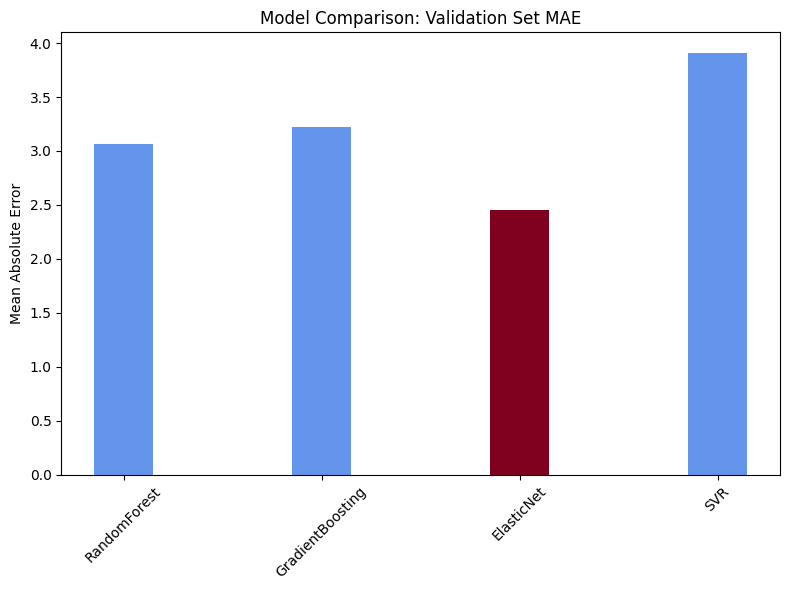

In [14]:
visualize_model_comparison(val_results)

# Visualize actual vs predicted values

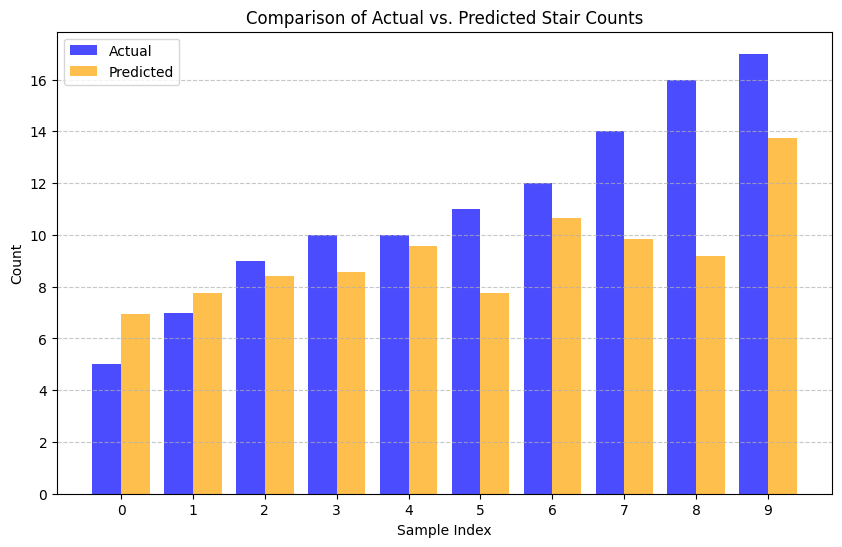

In [15]:
visualize_actual_vs_predicted(y_test, y_test_pred)